In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from IPython.display import display, clear_output

In [2]:
def S(k, r):
    exp_term = np.exp(1j * r @ k)
    s_eval = np.sum(exp_term, axis=0)
    return np.abs( s_eval )**2 / r.shape[0]

def S_0(k, K, D, H, alpha):
    
    s_0_eval = np.ones(shape=k.shape[1])
    kk = np.sum(k * k, axis=0)
    indeces = kk < K**2
    s_0_eval[indeces] = D * (1. - H) * kk[indeces]**(alpha/2.) + H
    return s_0_eval

def compute_dS_dr(k, r):
    """
    Compute derivative of S(k, r) with respect to r.
    k: shape (2, M)
    r: shape (N, 2)
    Returns: array of shape (N, 2, M)
    """
    N = r.shape[0]
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    exp_ikr = np.exp(1j * k_dot_r)  # (N, M)

    sum_exp = np.sum(exp_ikr, axis=0)  # (M,)

    # Now, compute derivatives
    dS_dr = np.zeros((N, 2, k.shape[1]), dtype=np.complex128)

    for d in range(2):  # For each spatial dimension (x and y)
        dS_dr[:, d, :] = (1j / N) * (k[d, np.newaxis, :] * (
            exp_ikr * np.conj(sum_exp[np.newaxis, :]) - 
            np.conj(exp_ikr) * sum_exp[np.newaxis, :]
        ))
    
    return dS_dr

def gen_hu_points(r_0, S_0, k, K, D, H, alpha):
    N = r_0.shape[0]
    target = S_0(k, K, D, H, alpha)

    def minimizer_func(r, k):
        r = r.reshape((-1, 2))
        diff = S(k, r) - target
        return np.dot(diff, diff)

    def jacobian_func(r, k):
        """
        Compute full gradient of F with respect to r.
        r: shape (N, 2)
        k: shape (2, M)
        Returns: shape (N, 2)
        """
        r = r.reshape(-1, 2)
        M = k.shape[1]

        S_kr = S(k, r)  # (M,)
        S0_k = target  # (M,)
        dSkr_dr = compute_dS_dr(k, r)  # (N, 2, M)

        diff = (S_kr - S0_k)  # (M,)

        # Now sum over k (axis=2)
        grad = 2 * np.real(np.sum(dSkr_dr * diff[np.newaxis, np.newaxis, :], axis=2))  # (N, 2)
        return grad.flatten()

    print(minimizer_func(r_0.flatten(), k))
    bounds = [(0.0, 1.0)] * (2 * N)
    r_new = r_0.flatten()
    # custom gradient descent:
    step_size = 0.000001
    for ii in range(2000):

        r_new -= step_size * jacobian_func(r_new, k)
        r_new = r_new % 1.0
        
        if (ii % 20 == 0):
            clear_output(wait=True)
            plt.pause(0.001)
            plt.scatter(r_new.reshape(-1, 2)[:, 0], r_new.reshape(-1, 2)[:, 1])
            plt.show()
            print("iter ",ii,"/2000")

    #opt = scp.optimize.minimize(minimizer_func, r_0.flatten(), args=(k, ) , bounds=bounds, jac=jacobian_func, method="L-BFGS-B",)
    print("before: ", minimizer_func(r_0.flatten(), k))
    print("after: ", minimizer_func(r_new.flatten(), k))
    opt = r_new
    return opt




In [3]:
def generate_k_vectors(K, L=1.0, num_per_dim=10):
    """
    Generate wavevectors with |k| < kmax
    on a uniform 2D grid in reciprocal space.
    """
    max_threshhold = 1.2*K**2
    min_threshhold = 1.

    kx = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi / L
    ky = np.fft.fftfreq(num_per_dim, d=1.0/num_per_dim) * 2 * np.pi / L
    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    k_flat = np.stack((kx.ravel(), ky.ravel()), axis=0)
    
    # Apply radial cutoff
    mag_k = np.sum(k_flat*k_flat, axis=0)
    mask = (mag_k > min_threshhold) & (mag_k < max_threshhold)
    return k_flat[:, mask]  # shape: (2, nk)


def grid_k_vectors(K, max_n=20):
    k_list = []
    for nx in range(-max_n, max_n+1, 2):
        for ny in range(-max_n, max_n+1, 2):
            if nx == 0 and ny == 0:
                continue
            k = 2 * np.pi * np.array([nx, ny])
            mag = np.sum(k*k)
            if  mag > 200. and mag < 1.2*K**2:
                k_list.append(k)
    return np.array(k_list).T


def generate_unit_circle_vectors(num_points):
    theta = np.random.uniform(0, 2 * np.pi, num_points)
    x = np.cos(theta)
    y = np.sin(theta)
    points = np.stack([x, y], axis=-1)
    return points

def generate_k_unit_even(num_points):
    theta = np.linspace(0, 2*np.pi, num_points, endpoint=False)
    x = np.cos(theta)
    y = np.sin(theta)
    points = np.stack([x, y], axis=-1)
    return points

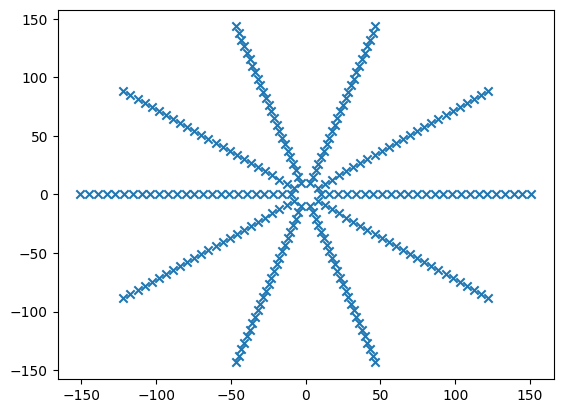

(2, 250)
(2, 27, 27)
(729, 2)


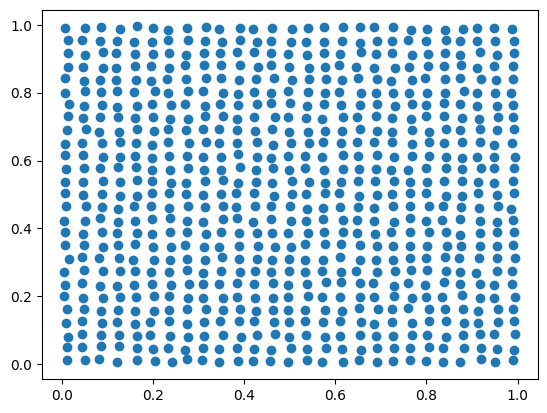

In [4]:
N = 27
k_N = 10

H = 1e-4
alpha = 100.
K = 40.*np.pi
# H = 1e-4
# alpha = 2.
# K = 44.*np.pi
D = np.pow(K, -alpha)

# k = 4 * np.pi * np.array([[n, n] for n in range(1, 11)]).T
# k = np.ones((2, k_N)) * np.linspace(4*np.pi, K, k_N)
# k = generate_k_vectors(K)
# k = grid_k_vectors(K)
# k = generate_unit_circle_vectors(k_N).T
# km = np.linspace(1., 1.2*K, 25)

# k[0, :] *= km
# k[1, :] *= km

kkkk = generate_k_unit_even(k_N).T
km = np.linspace(10., 1.2*K, 25)

kkkk_expanded = kkkk[:, :, np.newaxis]      # shape (2, 10, 1)
km_expanded = km[np.newaxis, np.newaxis, :]  # shape (1, 1, 25)

# Multiply → shape (2, 10, 25)
k = kkkk_expanded * km_expanded

# Reshape to (2, 250)
k = k.reshape(2, -1)



plt.scatter(k[0, :], k[1, :], marker="x")
plt.show()
print(k.shape)

space = np.linspace(0.01, .99, N)
r_0 = np.array(np.meshgrid(space, space))
print(r_0.shape)
pert_x = 0.005*np.random.uniform(-1, 1, size=(N, N))
pert_y = 0.005*np.random.uniform(-1, 1, size=(N, N))
r_0[0] += pert_x
r_0[1] += pert_y
r_0 = r_0.reshape(2,-1).T

#r_0 = np.random.uniform(size=(N, 2))
print(r_0.shape)
plt.scatter(r_0[:, 0], r_0[:, 1])
plt.show()

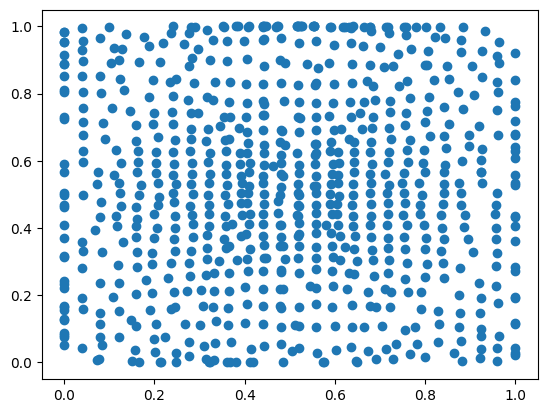

iter  1980 /2000
before:  2489.783206226782
after:  970.130205330642


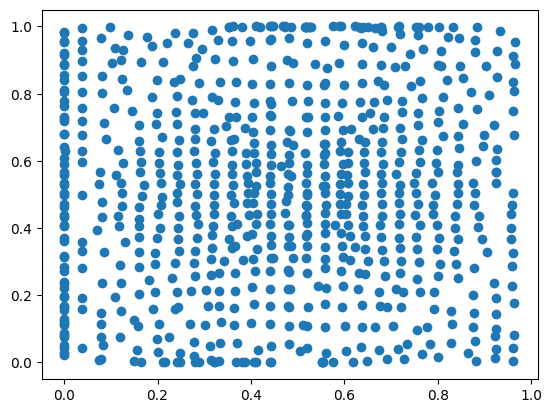

In [5]:
sol = gen_hu_points(r_0, S_0, k, K, D, H, alpha)

r = sol.reshape((-1, 2))
plt.scatter(r[:, 0], r[:, 1])
plt.show()

In [6]:
diff = r.flatten() - r_0.flatten()
print(np.sqrt(np.dot(diff, diff)))

7.921826636864565


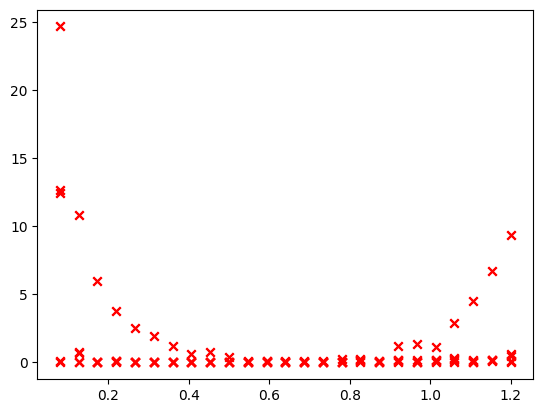

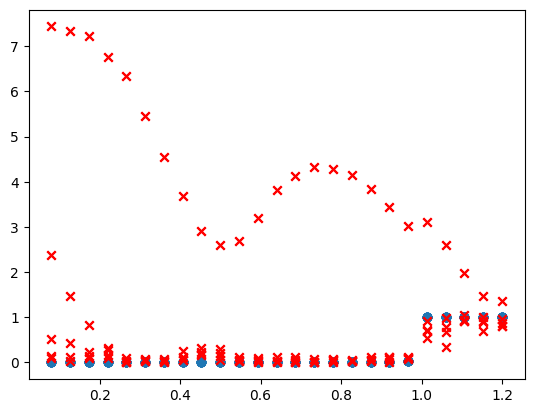

In [7]:
k_X = np.sqrt(np.sum(k*k, axis=0)) / K
plt.scatter(k_X, S(k, r_0), marker="x", color="red")
plt.show()
plt.scatter(k_X, S_0(k, K, D, H, alpha))
plt.scatter(k_X, S(k, r.reshape((-1, 2))), marker="x", color="red")
plt.show()

2495.947432461594
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0004444357075717098
        x: [ 9.685e-02  1.547e-02 ...  9.913e-01  9.796e-01]
      nit: 1228
      jac: [-3.028e-02 -3.097e-02 ...  1.066e-02  1.182e-02]
     nfev: 1298
     njev: 1298
 hess_inv: <1458x1458 LbfgsInvHessProduct with dtype=float64>


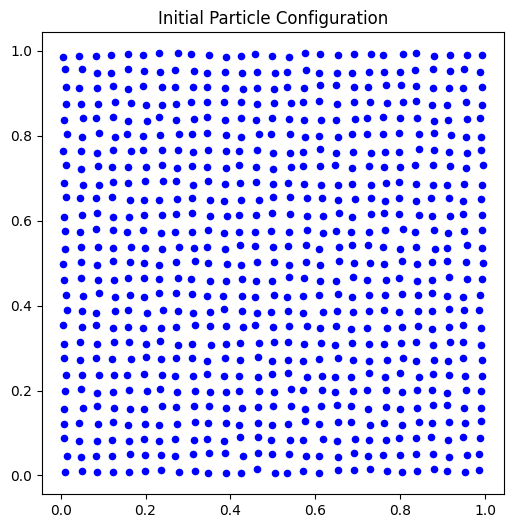

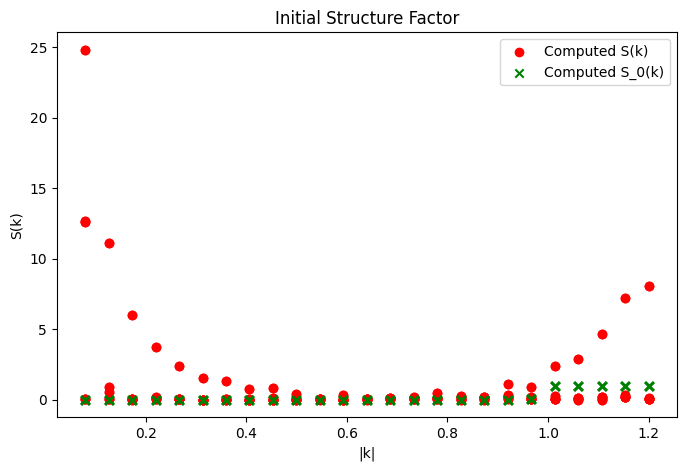

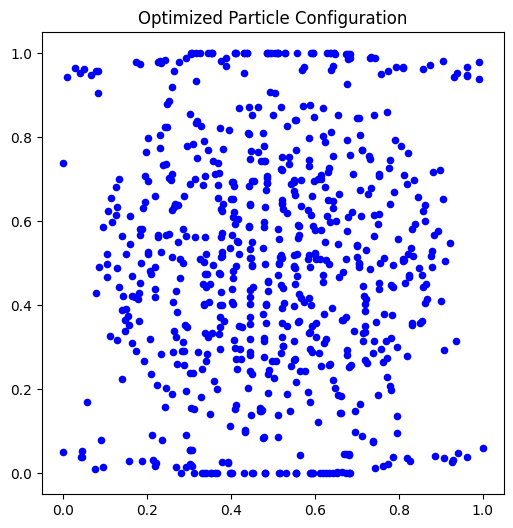

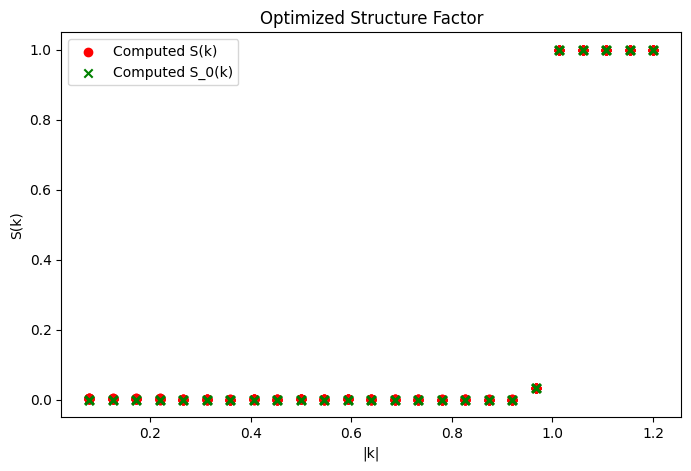

In [15]:
# do wit with scipy minimize

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------- Core Functions ---------- #

def compute_S(k, r):
    N = r.shape[0]
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    sum_exp = np.sum(np.exp(1j * k_dot_r), axis=0)  # (M,)
    return np.abs(sum_exp)**2 / N

def compute_S0(k, D, H, alpha, K_cutoff):
    k_magnitude = np.linalg.norm(k, axis=0)  # (M,)
    S0 = np.where(k_magnitude < K_cutoff, D * (1 - H) * (k_magnitude**alpha) + H, 1.0)
    return S0

def compute_dS_dr(k, r):
    N = r.shape[0]
    k_dot_r = np.tensordot(r, k, axes=([1], [0]))  # (N, M)
    exp_ikr = np.exp(1j * k_dot_r)  # (N, M)
    sum_exp = np.sum(exp_ikr, axis=0)  # (M,)

    dS_dr = np.zeros((N, 2, k.shape[1]), dtype=np.complex128)

    for d in range(2):  # x and y
        dS_dr[:, d, :] = (1j / N) * (k[d, np.newaxis, :] * (
            exp_ikr * np.conj(sum_exp[np.newaxis, :]) -
            np.conj(exp_ikr) * sum_exp[np.newaxis, :]
        ))
    return dS_dr

def compute_gradient_F(r, k, D, H, alpha, K_cutoff):
    S_kr = compute_S(k, r)  # (M,)
    S0_k = compute_S0(k, D, H, alpha, K_cutoff)  # (M,)
    dSkr_dr = compute_dS_dr(k, r)  # (N, 2, M)
    diff = (S_kr - S0_k)  # (M,)
    grad = 2 * np.real(np.sum(dSkr_dr * diff[np.newaxis, np.newaxis, :], axis=2))  # (N, 2)
    return grad

def objective_function(x, k, D, H, alpha, K_cutoff):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    S_kr = compute_S(k, r)
    S0_k = compute_S0(k, D, H, alpha, K_cutoff)
    return np.sum((S_kr - S0_k)**2)

def gradient_function(x, k, D, H, alpha, K_cutoff):
    N = x.shape[0] // 2
    r = x.reshape(N, 2)
    grad = compute_gradient_F(r, k, D, H, alpha, K_cutoff)
    return grad.flatten()

# ---------- Parameters ---------- #

N = int(np.sqrt(780))         
M = 100         # 100 wavevectors
np.random.seed(0)  # For reproducibility

#r_init = np.random.uniform(0, 1, size=(N, 2))  # Initial random positions
space = np.linspace(0.01, .99, 26)
r_init = np.array(np.meshgrid(space, space)).reshape(2,-1).T

space = np.linspace(0.01, .99, N)
r_init = np.array(np.meshgrid(space, space))
pert_x = 0.005*np.random.uniform(-1, 1, size=(N, N))
pert_y = 0.005*np.random.uniform(-1, 1, size=(N, N))
r_init[0] += pert_x
r_init[1] += pert_y
r_init = r_init.reshape(2,-1).T

kkkk = generate_k_unit_even(k_N).T
km = np.linspace(10., 1.2*K, 25)

kkkk_expanded = kkkk[:, :, np.newaxis]     # shape (2, 10, 1)
km_expanded = km[np.newaxis, np.newaxis, :]  # shape (1, 1, 25)

# Multiply → shape (2, 10, 25)
k = kkkk_expanded * km_expanded

# Reshape to (2, 250)
k = k.reshape(2, -1)


# Target structure factor parameters
H = 1e-4
alpha = 100.
K_cutoff = 40*np.pi
D = np.pow(K, -alpha)

# ---------- Run Optimization ---------- #
N = r_init.shape[0]
bounds = [(0.0, 1.0)] * (2 * N)
print(objective_function(r_init.flatten(), k, D, H, alpha, K_cutoff))
res = minimize(
    fun=objective_function,
    x0=r_init.flatten(),
    jac=gradient_function,
    args=(k, D, H, alpha, K_cutoff),
    method="L-BFGS-B",
    bounds=bounds,
    options={"disp": True, "maxiter": 10000}
)

# ---------- Postprocess ---------- #

r_opt = res.x.reshape(N, 2)  # Final particle positions
print(res)
# ---------- Visualization ---------- #

def plot_particles(r, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(r[:, 0], r[:, 1], c="blue", s=20)
    plt.title(title)
    # plt.xlim(0, 1)
    # plt.ylim(0, 1)
    plt.gca().set_aspect('equal')
    plt.show()

def plot_structure_factor(r, k, title):
    S_kr = compute_S(k, r)
    S_0_k = compute_S0(k, D, H, alpha, K_cutoff)
    k_magnitude = np.linalg.norm(k, axis=0)
    plt.figure(figsize=(8, 5))
    plt.scatter(k_magnitude/K_cutoff, S_kr, color="red", label="Computed S(k)")
    plt.scatter(k_magnitude/K_cutoff, S_0_k, color="green", label="Computed S_0(k)", marker="x")
    plt.xlabel("|k|")
    plt.ylabel("S(k)")
    plt.title(title)
    plt.legend()
    plt.show()

# Plot before optimization
plot_particles(r_init, "Initial Particle Configuration")
plot_structure_factor(r_init, k, "Initial Structure Factor")

# Plot after optimization
plot_particles(r_opt, "Optimized Particle Configuration")
plot_structure_factor(r_opt, k, "Optimized Structure Factor")


Minimize:
\begin{equation*}
    F(r) = \Sigma_k |S(k, r) - S_0(k)|^2, r \in \mathbb{R}^N
\end{equation*}
where
\begin{equation*}
    S(k, r) = \frac{1}{N}|\Sigma^N_{j=1} exp(iK*r_j)|^2
\end{equation*}
and $S_0$ is the prescribed structure factor. We may parameterize $S_0(k)$ as 
\begin{equation*}
    S_0(k) = D (1 - H) |k|^\alpha + H, |k|<K; = 1, else
\end{equation*}